In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

from dd_kable_analysis.config_loader import load_config
from dd_kable_analysis.tseries_model.tseries_model_qa import make_design_qa_figure

# What is this?

This notebook performs quality assurance (QA) on the design matrices prior to model estimation.

### Incomplete BOLD Runs

Many subjects’ BOLD runs did not extend long enough to capture the final trial(s).

To avoid singular or ill-conditioned design matrices:

* I check whether any trial onset times occur after the final acquired frame.

* If only one trial occurs beyond the last frame, that trial is omitted.

* If multiple trials occur beyond the last frame, the design matrix for that run is not generated.

### Variance Inflation Factors (VIFs)

Variance inflation factors were estimated for:

* The beta-series regressors

* The ll-ss contrast

Observations:

* VIFs are generally excellent (most < 5).

* Beta estimates will be further monitored for outlier runs after model estimation.

### Runs Excluded from Design Generation

Design matrices will not be generated for:

* sub=dmp0063, run=2 — ❌ 17 trials are clipped beyond the final frame.

In [2]:
cfg = load_config()
good_subs_csv = cfg.subject_lists / 'initial_qa_pass_subjects_runs.csv'
good_subs = pd.read_csv(good_subs_csv)

In [3]:
out_pdf = Path('./figures/design_matrix_assessment.pdf')
out_pdf.parent.mkdir(parents=True, exist_ok=True)

vif_all = []

with PdfPages(out_pdf) as pdf:
    for row in good_subs.itertuples(index=False):
        sub_id = row.sub_id
        run = row.run
        print(f'Processing sub={sub_id}, run={run}...')
        fig = None
        try:
            fig, vifs = make_design_qa_figure(cfg, sub_id, run)
            pdf.savefig(fig, bbox_inches='tight')
            vifs['sub_id'] = sub_id
            vifs['run'] = run
            vif_all.append(vifs)
        except Exception as e:
            print(f'⚠️ Error for sub={sub_id}, run={run}: {e}')
        finally:
            if fig is not None:
                plt.close(fig)


Processing sub=dmp0011, run=1...
Processing sub=dmp0011, run=2...
Processing sub=dmp0011, run=3...
Processing sub=dmp0011, run=4...
Processing sub=dmp0019, run=1...
Processing sub=dmp0019, run=2...
Processing sub=dmp0019, run=3...
Processing sub=dmp0019, run=4...
Processing sub=dmp0048, run=1...
Processing sub=dmp0048, run=2...
Processing sub=dmp0048, run=3...
Processing sub=dmp0048, run=4...
Processing sub=dmp0060, run=2...
Processing sub=dmp0060, run=3...
Processing sub=dmp0060, run=4...
Processing sub=dmp0062, run=1...
Processing sub=dmp0062, run=2...
Processing sub=dmp0062, run=3...
Processing sub=dmp0062, run=4...
Processing sub=dmp0063, run=1...
Processing sub=dmp0063, run=2...
⚠️ Error for sub=dmp0063, run=2: ❌ 16 trials for sub dmp0063, run 2 are clipped. Cannot generate design matrix.
Processing sub=dmp0063, run=3...
Processing sub=dmp0063, run=4...
Processing sub=dmp0090, run=1...
Processing sub=dmp0090, run=2...
Processing sub=dmp0090, run=3...
Processing sub=dmp0090, run=4.

## VIFs generally look great

In [4]:
vif_all_df = pd.concat(vif_all)


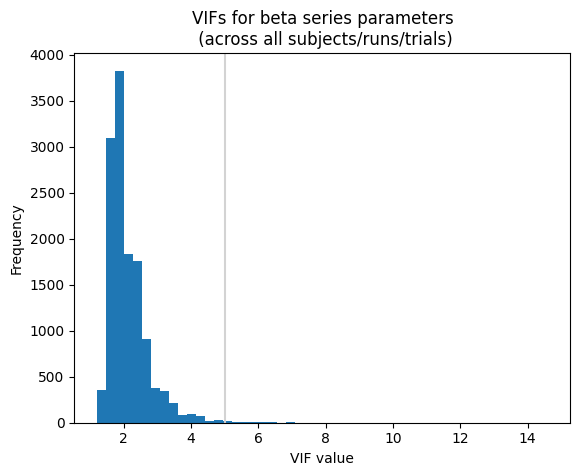

In [5]:
trial_cols = [col for col in vif_all_df.columns if col.startswith('trial')]

# Extract values, flatten, and drop NaNs
trial_values = vif_all_df[trial_cols].values.ravel()
trial_values = trial_values[~np.isnan(trial_values)]

# Plot histogram
plt.figure()
plt.hist(trial_values, bins=50)
plt.axvline(x=5, color='lightgray')
plt.xlabel('VIF value')
plt.ylabel('Frequency')
plt.title('VIFs for beta series parameters\n (across all subjects/runs/trials)')
plt.show()

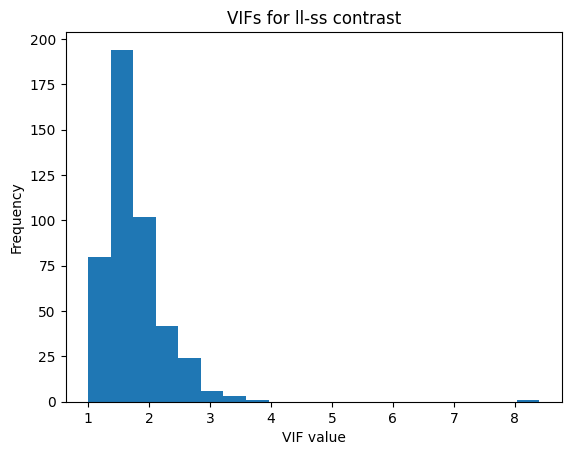

In [6]:
plt.hist(vif_all_df['ll_minus_ss'], 20)
plt.xlabel('VIF value')
plt.ylabel('Frequency')
plt.title('VIFs for ll-ss contrast')
plt.show()

In [18]:
vif_all_df

,trial00,trial01,trial02,trial03,trial04,trial05,trial06,trial07,trial08,trial09,...,trial22,trial23,trial24,trial25,trial26,trial27,trial28,ll_minus_ss,sub_id,run
0,2.7,1.8,1.7,1.9,1.9,2.2,2.4,1.6,1.9,2.0,...,1.9,1.8,1.4,1.8,1.9,2.0,2.2,1.9,dmp0011,1
0,2.1,1.4,1.8,1.9,1.6,1.6,1.6,1.7,2.0,1.6,...,1.9,1.7,1.6,1.7,1.6,1.8,2.2,1.4,dmp0011,2
0,1.9,1.3,1.6,1.6,1.9,2.1,1.8,1.5,1.6,2.6,...,1.8,1.9,2.1,2.2,2.1,2.2,3.1,2.4,dmp0011,3
0,1.5,2.1,2.2,1.3,1.7,1.7,2.2,1.7,2.2,1.7,...,1.5,1.7,1.7,1.8,1.9,2.2,2.3,1.3,dmp0011,4
0,2.3,2.0,2.0,2.1,1.6,1.7,2.2,1.8,2.5,1.6,...,1.8,1.7,1.7,2.4,2.1,2.1,3.3,1.2,dmp0019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2.4,2.3,2.6,1.8,2.0,2.1,2.0,2.0,2.0,2.1,...,1.6,1.4,1.5,1.5,2.3,1.9,2.7,1.9,dmp1271,4
0,1.9,1.7,1.8,1.8,1.9,1.8,3.1,2.2,1.8,1.9,...,1.6,2.1,2.9,1.8,1.6,1.9,2.6,1.1,dmp1291,1
0,1.7,1.7,1.7,2.0,2.3,4.9,2.7,2.3,1.9,1.8,...,2.1,2.2,2.2,2.5,2.6,3.6,3.5,2.2,dmp1291,2
0,2.6,1.8,2.2,2.2,1.5,2.2,2.6,1.7,2.3,1.5,...,1.7,2.0,1.9,2.0,1.9,2.1,2.2,1.1,dmp1291,3


In [19]:
vif_long_df = vif_all_df.drop(columns=['ll_minus_ss'], errors='ignore').melt(
    id_vars=['sub_id', 'run'], var_name='trial', value_name='vif'
)

vif_long_df

,sub_id,run,trial,vif
0,dmp0011,1,trial00,2.7
1,dmp0011,2,trial00,2.1
2,dmp0011,3,trial00,1.9
3,dmp0011,4,trial00,1.5
4,dmp0019,1,trial00,2.3
...,...,...,...,...
13132,dmp1271,4,trial28,2.7
13133,dmp1291,1,trial28,2.6
13134,dmp1291,2,trial28,3.5
13135,dmp1291,3,trial28,2.2


In [24]:
vif_gt5 = vif_long_df.loc[vif_long_df['vif'] > 5].sort_values('sub_id')

vif_gt5.to_csv('subject_lists/vif_gt_5.csv', index=False)

print(vif_gt5)

        sub_id  run    trial   vif
911    dmp0019    2  trial02   6.6
12698  dmp0060    4  trial28   5.7
9525   dmp0060    2  trial21   5.8
918    dmp0060    2  trial02   6.2
2279   dmp0060    4  trial05   6.0
6866   dmp0169    1  trial15   5.7
12765  dmp0183    3  trial28   9.1
12773  dmp0217    3  trial28   8.6
10074  dmp0295    4  trial22   5.1
10082  dmp0305    4  trial22   6.1
2386   dmp0330    1  trial05   5.1
1943   dmp0356    4  trial04   5.4
5573   dmp0381    3  trial12  13.5
3314   dmp0418    1  trial07   5.3
6952   dmp0498    2  trial15   5.1
10138  dmp0521    2  trial22   5.9
12859  dmp0523    4  trial28   5.4
12863  dmp0528    4  trial28   5.2
9693   dmp0556    1  trial21   6.9
6081   dmp0574    1  trial13   6.9
8360   dmp0649    1  trial18   5.9
4740   dmp0678    1  trial10   6.2
4287   dmp0678    1  trial09   5.2
7479   dmp0730    4  trial16   5.9
12918  dmp0755    3  trial28   9.6
7495   dmp0773    1  trial16   6.2
2523   dmp0782    4  trial05   5.9
12939  dmp0782    1 